# Data Science Professional Certificate - Capstone Project

This notebook will be used for the Capstone Project of IBM Data Science Professional Certificate hosted on Coursera.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import utils
import itertools
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


### Part I: Prepare Data

Prepare neighborhood data from Wikipedia: https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius.

In [2]:
wiki_tables = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_of_Vilnius')

In [3]:
wiki_tables[0]

,Unnamed: 0,Neighborhoods,Area (km2)[1],Pop. (2001)[1],Density (2001)[1],Latitude,Longitude
0,1,Verkiai,56.0,30856,551.0,54.708707,25.284686
1,2,Antakalnis,77.2,39697,514.2,54.701126,25.308957
2,3,Pašilaičiai,7.9,25674,3249.9,54.725942,25.231328
3,4,Fabijoniškės,5.9,36644,6210.8,54.723397,25.249529
4,5,Pilaitė,13.9,15996,1150.8,54.708126,25.175803
5,6,Justiniškės,3.0,30958,10319.3,54.717905,25.220236
6,7,Viršuliškės,2.6,16250,6250.0,54.717867,25.220222
7,8,Šeškinė,4.6,36604,7957.4,54.715694,25.244574
8,9,Šnipiškės,3.1,19321,6232.6,54.692956,25.285007
9,10,Žirmūnai,5.7,47410,8317.5,54.723249,25.297213


Take the dataset and drop unnecesary columns.

In [4]:
df_wiki = wiki_tables[0].drop(columns=['Unnamed: 0', 'Pop. (2001)[1]', 'Density (2001)[1]'])

Rename remaining columns to more convenient names.

In [5]:
df_wiki.rename(columns={'Neighborhoods': 'neighborhood', 'Area (km2)[1]': 'area', 'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

Prepare real estate pricing data that was prepared manually using the following resource: https://en.aruodas.lt/kainu-statistika/.

In [6]:
df_price = pd.read_csv('../data/vilnius_real_estate_prices.csv').drop(columns='Unnamed: 4')

In [7]:
df_price.head(10)

,neighborhood,date,flat_price_per_sqm,house_price_per_sqm
0,Verkiai,2015,2438.88,962.88
1,Verkiai,2016,2188.20,1042.48
2,Verkiai,2017,2123.95,1163.34
3,Verkiai,2018,2328.84,1302.48
4,Verkiai,2019,2542.43,1234.01
5,Antakalnis,2015,1712.65,1121.87
6,Antakalnis,2016,1765.60,1258.29
7,Antakalnis,2017,1883.70,1249.95
8,Antakalnis,2018,2079.65,1309.00
9,Antakalnis,2019,2159.75,1204.06


In [8]:
df_price['date'] = df_price['date'].astype(str)

Pivoting the table to make the calculation of price increase in percentages easier.

In [9]:
df_piv = df_price.pivot(index='neighborhood', columns='date', values=['flat_price_per_sqm', 'house_price_per_sqm']).reset_index()

In [10]:
# https://stackoverflow.com/questions/27071661/pivoting-pandas-dataframe-into-prefixed-cols-not-a-multiindex
df_piv.columns = ['_'.join(col).strip() for col in df_piv.columns]

In [11]:
df_piv.rename(columns={'neighborhood_': 'neighborhood'}, inplace=True)

In [12]:
df_piv.head()

,neighborhood,flat_price_per_sqm_2015,flat_price_per_sqm_2016,flat_price_per_sqm_2017,flat_price_per_sqm_2018,flat_price_per_sqm_2019,house_price_per_sqm_2015,house_price_per_sqm_2016,house_price_per_sqm_2017,house_price_per_sqm_2018,house_price_per_sqm_2019
0,Antakalnis,1712.65,1765.60,1883.70,2079.65,2159.75,1121.87,1258.29,1249.95,1309.00,1204.06
1,Fabijoniškės,1314.05,1362.96,1418.37,1451.09,1487.74,875.79,821.89,1027.83,1189.95,1085.74
2,Grigiškės,908.17,576.28,1251.76,1455.94,1076.84,778.37,754.49,882.99,758.15,902.68
3,Justiniškės,1180.37,1254.17,1419.11,1435.46,1561.02,861.15,890.67,1114.67,1379.03,1766.02
4,Karoliniškės,1662.53,1795.17,1894.88,1756.66,2193.33,1196.78,1321.02,1387.47,1155.58,1326.13


In [13]:
def get_price_change_percentages(row, year, prev_year):
    return round((row[year] - row[prev_year]) / row[prev_year] * 100, 2)

In [14]:
for year in range(2016, 2020):
    df_piv[f'flat_perc_{year}_vs_{year-1}'] = df_piv.apply(get_price_change_percentages, args=(f'flat_price_per_sqm_{year}', f'flat_price_per_sqm_{year-1}'), axis=1)
    df_piv[f'house_perc_{year}_vs_{year-1}'] = df_piv.apply(get_price_change_percentages, args=(f'house_price_per_sqm_{year}', f'house_price_per_sqm_{year-1}'), axis=1)

In [15]:
df_piv.drop(columns=['flat_price_per_sqm_2015', 'flat_price_per_sqm_2016', 'flat_price_per_sqm_2017', 'flat_price_per_sqm_2018',
                     'house_price_per_sqm_2015', 'house_price_per_sqm_2016', 'house_price_per_sqm_2017', 'house_price_per_sqm_2018'],
            inplace=True)

In [16]:
df_piv.head()

,neighborhood,flat_price_per_sqm_2019,house_price_per_sqm_2019,flat_perc_2016_vs_2015,house_perc_2016_vs_2015,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,flat_perc_2019_vs_2018,house_perc_2019_vs_2018
0,Antakalnis,2159.75,1204.06,3.09,12.16,6.69,-0.66,10.40,4.72,3.85,-8.02
1,Fabijoniškės,1487.74,1085.74,3.72,-6.15,4.07,25.06,2.31,15.77,2.53,-8.76
2,Grigiškės,1076.84,902.68,-36.54,-3.07,117.21,17.03,16.31,-14.14,-26.04,19.06
3,Justiniškės,1561.02,1766.02,6.25,3.43,13.15,25.15,1.15,23.72,8.75,28.06
4,Karoliniškės,2193.33,1326.13,7.98,10.38,5.55,5.03,-7.29,-16.71,24.86,14.76


In [17]:
df_join = df_wiki.merge(df_piv, on='neighborhood')

In [18]:
df_join.head()

,neighborhood,area,latitude,longitude,flat_price_per_sqm_2019,house_price_per_sqm_2019,flat_perc_2016_vs_2015,house_perc_2016_vs_2015,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,flat_perc_2019_vs_2018,house_perc_2019_vs_2018
0,Verkiai,56.0,54.708707,25.284686,2542.43,1234.01,-10.28,8.27,-2.94,11.59,9.65,11.96,9.17,-5.26
1,Antakalnis,77.2,54.701126,25.308957,2159.75,1204.06,3.09,12.16,6.69,-0.66,10.40,4.72,3.85,-8.02
2,Pašilaičiai,7.9,54.725942,25.231328,1346.12,1355.49,6.19,-12.83,9.50,19.07,-4.15,23.76,3.04,7.99
3,Fabijoniškės,5.9,54.723397,25.249529,1487.74,1085.74,3.72,-6.15,4.07,25.06,2.31,15.77,2.53,-8.76
4,Pilaitė,13.9,54.708126,25.175803,1527.27,1079.82,3.01,0.70,8.35,8.53,-1.76,6.80,4.42,4.43


### Part II: Extract Foursquare Data

Coordinates of Vilnius (got them manually by doing a Google search):

In [19]:
vilnius_lat = 54.6872
vilnius_lng = 25.2797

Plot Vilnius map with neighborhoods.

In [20]:
map_vilnius = folium.Map(location=[vilnius_lat, vilnius_lng], zoom_start=12)

for lat, lng, neighborhood in zip(df_join['latitude'], df_join['longitude'], df_join['neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_vilnius)
    
map_vilnius

Looking at the map it's quite obvious that neighborhood coordinates are wrong. It seems that the Wikipedia page has wrong coordinates entered. We need to get more exact coordinates in a different way. Let's try using Nominatim within geopy library.

In [21]:
geolocator = Nominatim(user_agent='') # Add your user agent here

for index, row in df_join.iterrows():
    neighborhood = row['neighborhood']
    
    g = geolocator.geocode(f'{neighborhood}, Vilnius, Lithuania')
    
    df_join.loc[index, 'latitude'] = g.latitude
    df_join.loc[index, 'longitude'] = g.longitude
    
    if (index % 9) == 0:
        print('10 rows processed')

10 rows processed
10 rows processed
10 rows processed


In [22]:
map_vilnius = folium.Map(location=[vilnius_lat, vilnius_lng], zoom_start=12)

for lat, lng, neighborhood in zip(df_join['latitude'], df_join['longitude'], df_join['neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_vilnius)
    
map_vilnius

Beautiful, geopy and Nominatim library did its magic.

Get Vilnius venues for each neighborhood using the Foursquare API. See the function in utils.py for details.

In [23]:
# Add Foursquare API key, secret and version to utils.py for this to work
vilnius_venues = utils.get_nearby_venues(names=df_join['neighborhood'],
                                         latitudes=df_join['latitude'],
                                         longitudes=df_join['longitude'],
                                         radiuses=np.sqrt(df_join['area']*1000000/3.14)) # Getting radius from area with this transformation

Verkiai
Antakalnis
Pašilaičiai
Fabijoniškės
Pilaitė
Justiniškės
Viršuliškės
Šeškinė
Šnipiškės
Žirmūnai
Karoliniškės
Žvėrynas
Grigiškės
Lazdynai
Vilkpėdė
Naujamiestis
Senamiestis
Naujoji Vilnia
Paneriai
Naujininkai
Rasos


In [24]:
vilnius_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Verkiai,54.750657,25.294767,Verkių regioninis parkas | Verkiai Regional park,54.751579,25.293919,Park
1,Verkiai,54.750657,25.294767,Verkių dvaro rūmai,54.748114,25.292627,History Museum
2,Verkiai,54.750657,25.294767,Rupert,54.742793,25.294918,Art Gallery
3,Verkiai,54.750657,25.294767,Valakampių II-asis paplūdimys,54.742791,25.294941,Beach
4,Verkiai,54.750657,25.294767,Vilniaus Kalvarijos Kryžiaus Kelias,54.730903,25.286888,Trail


Looks great so far.

In [25]:
vilnius_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            532 non-null    object 
 1   Neighborhood Latitude   532 non-null    float64
 2   Neighborhood Longitude  532 non-null    float64
 3   Venue                   532 non-null    object 
 4   Venue Latitude          532 non-null    float64
 5   Venue Longitude         532 non-null    float64
 6   Venue Category          532 non-null    object 
dtypes: float64(4), object(3)
memory usage: 29.2+ KB


Perform one-hot-encoding by venue category. This is to be used for clustering later on.

In [26]:
# One hot encoding
vilnius_onehot = pd.get_dummies(vilnius_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
vilnius_onehot['Neighborhood'] = vilnius_venues['Neighborhood'] 

# Move neighborhood column to the first column
neighborhood = vilnius_onehot['Neighborhood']
vilnius_onehot.drop(columns='Neighborhood', inplace=True)
vilnius_onehot.insert(0, 'Neighborhood', neighborhood)

vilnius_onehot.head()

,Neighborhood,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,...,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Verkiai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Verkiai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Verkiai,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Verkiai,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Verkiai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
vilnius_onehot.shape

(532, 140)

Get the mean of each venue category per neighborhood.

In [28]:
vilnius_grouped = vilnius_onehot.groupby('Neighborhood').mean().reset_index()

In [29]:
vilnius_grouped.head()

,Neighborhood,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,...,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Antakalnis,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.033333,0.0,...,0.0,0.0,0.0,0.033333,0.000000,0.033333,0.0,0.0,0.000000,0.0
1,Fabijoniškės,0.000000,0.0,0.0,0.000000,0.033333,0.0,0.033333,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.0
2,Grigiškės,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,Justiniškės,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,Karoliniškės,0.000000,0.0,0.0,0.047619,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.047619,0.000000,0.0,0.0,0.000000,0.0


Take top 10 venue categories for each neighborhood and sort by mean. See the function in utils.py for additional details.

In [30]:
vilnius_venues_sorted = utils.sort_neighborhood_venues(vilnius_grouped)

In [31]:
vilnius_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antakalnis,Hotel,Gym / Fitness Center,Pizza Place,Scenic Lookout,Art Gallery,Supermarket,Optical Shop,Park,Dance Studio,Plaza
1,Fabijoniškės,Fast Food Restaurant,Pizza Place,Food & Drink Shop,Gym / Fitness Center,Eastern European Restaurant,Grocery Store,Flower Shop,Food Truck,Market,Electronics Store
2,Grigiškės,Pharmacy,River,Grocery Store,Bus Stop,Yoga Studio,Eastern European Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store
3,Justiniškės,Supermarket,Pizza Place,Gas Station,Sporting Goods Shop,Shopping Mall,Bus Station,Market,Flea Market,Furniture / Home Store,Cosmetics Shop
4,Karoliniškės,Grocery Store,Office,Diner,Pizza Place,Bed & Breakfast,Paper / Office Supplies Store,Other Great Outdoors,Restaurant,Fast Food Restaurant,Bowling Alley
5,Lazdynai,Grocery Store,Pizza Place,Café,Fast Food Restaurant,Park,Restaurant,Gym,Office,TV Station,Soccer Field
6,Naujamiestis,Coffee Shop,Café,Pizza Place,Pub,Bed & Breakfast,Bistro,Hookah Bar,Flower Shop,Eastern European Restaurant,Diner
7,Naujininkai,Café,Pizza Place,Bar,Hotel,Coffee Shop,Restaurant,Gym,Food Court,Museum,Pub
8,Naujoji Vilnia,Park,Trail,Grocery Store,Eastern European Restaurant,Convenience Store,Restaurant,Mountain,Gastropub,Dance Studio,Supermarket
9,Paneriai,Restaurant,Diner,Fast Food Restaurant,Park,Burger Joint,Shopping Mall,Market,Supermarket,Eastern European Restaurant,Furniture / Home Store


### Part III: Clustering

First, perform clustering on the neighborhoods using the Foursquare data. We will try to repeat the clustering with real estate price data added later as well, to compare the clustering results. To start with, identify the number of clusters to be used with the elbow method.

In [32]:
X = vilnius_grouped.sort_values(by='Neighborhood').drop(columns=['Neighborhood'])

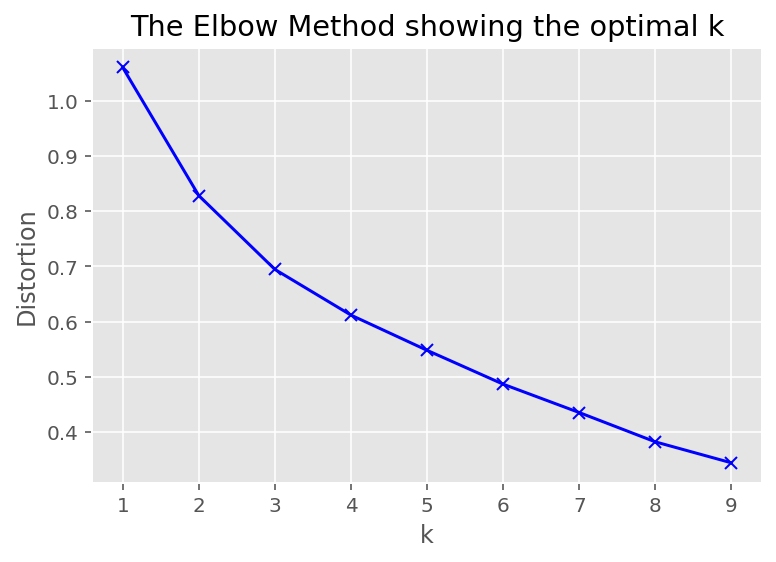

In [33]:
# Drawing inspiration from https://pythonprogramminglanguage.com/kmeans-elbow-method/

distortions = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=50).fit(X)
    distortions.append(kmeans.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method is not obvious here at all – the slope doesn't have a drastic change at any point. The slope changes slightly at 2-3 clusters, but that seems a bit too little, so let's intuitively use a sligthly larger cluster number of 5 (using a few more clusters won't make the results worse). That's also a decent number of clusters to analyze manually later on.

In [34]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, n_init=50, random_state=42)
kmeans = kmeans.fit(X)

In [35]:
vilnius_venues_sorted.sort_values(by='Neighborhood', inplace=True)
vilnius_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [36]:
vilnius_merged = df_join[['neighborhood', 'latitude', 'longitude']].merge(vilnius_venues_sorted, left_on='neighborhood', right_on='Neighborhood').drop(columns='Neighborhood')

In [37]:
vilnius_merged.head()

,neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Verkiai,54.750657,25.294767,4,Grocery Store,Park,Burger Joint,Trail,History Museum,Gaming Cafe,Pizza Place,Movie Theater,Italian Restaurant,Hotel
1,Antakalnis,54.705639,25.314538,1,Hotel,Gym / Fitness Center,Pizza Place,Scenic Lookout,Art Gallery,Supermarket,Optical Shop,Park,Dance Studio,Plaza
2,Pašilaičiai,54.728487,25.228916,3,Pizza Place,Fast Food Restaurant,Gym,Food & Drink Shop,Gym / Fitness Center,Convenience Store,Electronics Store,Market,Burger Joint,Soccer Field
3,Fabijoniškės,54.726411,25.249242,3,Fast Food Restaurant,Pizza Place,Food & Drink Shop,Gym / Fitness Center,Eastern European Restaurant,Grocery Store,Flower Shop,Food Truck,Market,Electronics Store
4,Pilaitė,54.705676,25.183502,4,Grocery Store,Coffee Shop,Bus Station,Gas Station,Lake,Steakhouse,Supermarket,Kebab Restaurant,Forest,Hotel


Plot neighborhoods colored by the corresponding cluster they were assigned to.

In [38]:
map_clusters = folium.Map(location=[vilnius_lat, vilnius_lng], zoom_start=12)

colors = ['darkred', 'green', 'darkblue', 'orange', 'black']

for lat, lon, neighborhood, cluster in zip(vilnius_merged['latitude'], vilnius_merged['longitude'], vilnius_merged['neighborhood'], vilnius_merged['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=colors[cluster],
    fill=True,
    fill_color=colors[cluster],
    fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

Let's try performing clustering including real estate pricing data. There is just one thing to do that: it would be great to add distance to city centre as a feature to the dataset.

In [39]:
# Consider the neighborhood Senamiestis (Old Town) as the city centre
center_lat = df_join[df_join['neighborhood'] == 'Senamiestis']['latitude'].values[0]
center_lon = df_join[df_join['neighborhood'] == 'Senamiestis']['longitude'].values[0]

In [40]:
df_join['distance_to_center'] = df_join.apply(lambda x: geodesic((x['latitude'], x['longitude']), (center_lat, (center_lon))).kilometers, axis=1)

In [41]:
df_full = df_join.merge(vilnius_grouped, left_on='neighborhood', right_on='Neighborhood').drop(columns='Neighborhood')

Perform clustering with the new dataset containing all information.

In [42]:
X = df_full.sort_values(by='neighborhood').drop(columns=['neighborhood', 'area', 'latitude', 'longitude'])

Scale the features before applying clustering.

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Let's cluster using 5 clusters as before, to see whether there will be any changes to resulting clusters.

In [44]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, n_init=50, random_state=42)
kmeans = kmeans.fit(X_scaled)

In [45]:
vilnius_sorted_full = utils.sort_neighborhood_venues(vilnius_grouped)

In [46]:
vilnius_sorted_full.sort_values(by='Neighborhood', inplace=True)
vilnius_sorted_full.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
vilnius_sorted_full.sort_values(by='Neighborhood', inplace=True)
vilnius_merged_full = df_join[['neighborhood', 'latitude', 'longitude', 'distance_to_center',
                               'flat_price_per_sqm_2019', 'flat_perc_2019_vs_2018',
                               'flat_perc_2017_vs_2016', 'house_perc_2017_vs_2016',
                               'house_price_per_sqm_2019', 'house_perc_2019_vs_2018',
                               'flat_perc_2018_vs_2017', 'house_perc_2018_vs_2017']].merge(vilnius_sorted_full, left_on='neighborhood', right_on='Neighborhood').drop(columns='Neighborhood')

Plot neighborhoods colored by the corresponding cluster they were assigned to.

In [48]:
map_clusters = folium.Map(location=[vilnius_lat, vilnius_lng], zoom_start=12)

colors = ['darkred', 'green', 'darkblue', 'orange', 'black']

for lat, lon, neighborhood, cluster, flat_price_per_sqm_2019, \
    house_price_per_sqm_2019, flat_perc_2019_vs_2018, \
    house_perc_2019_vs_2018, flat_perc_2018_vs_2017, \
    house_perc_2018_vs_2017, flat_perc_2017_vs_2016, \
    house_perc_2017_vs_2016 in zip(vilnius_merged_full['latitude'], vilnius_merged_full['longitude'],
                                   vilnius_merged_full['neighborhood'], vilnius_merged_full['Cluster Labels'],
                                   df_join['flat_price_per_sqm_2019'], df_join['house_price_per_sqm_2019'],
                                   df_join['flat_perc_2019_vs_2018'], df_join['house_perc_2019_vs_2018'],
                                   df_join['flat_perc_2018_vs_2017'], df_join['house_perc_2018_vs_2017'],
                                   df_join['flat_perc_2017_vs_2016'], df_join['house_perc_2017_vs_2016']):
    html = f'''{neighborhood} – Cluster {cluster}.<br><br>
             2019 flat price per sqm: {flat_price_per_sqm_2019}; 2019 house price per sqm: {house_price_per_sqm_2019}<br>
             2019 vs 2018 flat price increase: {flat_perc_2019_vs_2018}%; 2019 vs 2018 house price increase: {house_perc_2019_vs_2018}%<br>
             2018 vs 2017 flat price increase: {flat_perc_2018_vs_2017}%; 2018 vs 2017 house price increase: {house_perc_2018_vs_2017}%<br>
             2017 vs 2016 flat price increase: {flat_perc_2017_vs_2016}%; 2017 vs 2016 house price increase: {house_perc_2017_vs_2016}%
            '''
    iframe = folium.IFrame(html=html, width=600, height=150)
    label = folium.Popup(iframe, parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=colors[cluster],
    fill=True,
    fill_color=colors[cluster],
    fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

We can see that the resulting clusters are very different. The next step would be to analyze these clusters, to gain insights into why these neighborhoods are clustered as they are. First table below is an overview of cluster center values for price features.

In [49]:
df_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_)[:,:10], columns=X.columns[:10])
df_cluster_centers

,flat_price_per_sqm_2019,house_price_per_sqm_2019,flat_perc_2016_vs_2015,house_perc_2016_vs_2015,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,flat_perc_2019_vs_2018,house_perc_2019_vs_2018
0,2251.960000,1269.5000,2.930000,16.010000,11.200000,32.510000,4.570000,-11.520000,9.230000,-24.540000
1,1631.814167,1166.9075,-1.814167,2.981667,17.241667,16.699167,3.629167,1.818333,4.224167,10.774167
2,1658.840000,1389.7900,-3.150000,-27.210000,12.860000,44.120000,-0.760000,-2.130000,-18.660000,-14.900000
3,2621.780000,1757.0350,3.455000,0.805000,5.598333,5.738333,9.863333,11.718333,13.558333,-2.123333
4,1549.240000,1226.9200,1.820000,45.270000,5.890000,56.580000,-0.360000,64.680000,0.080000,-56.540000


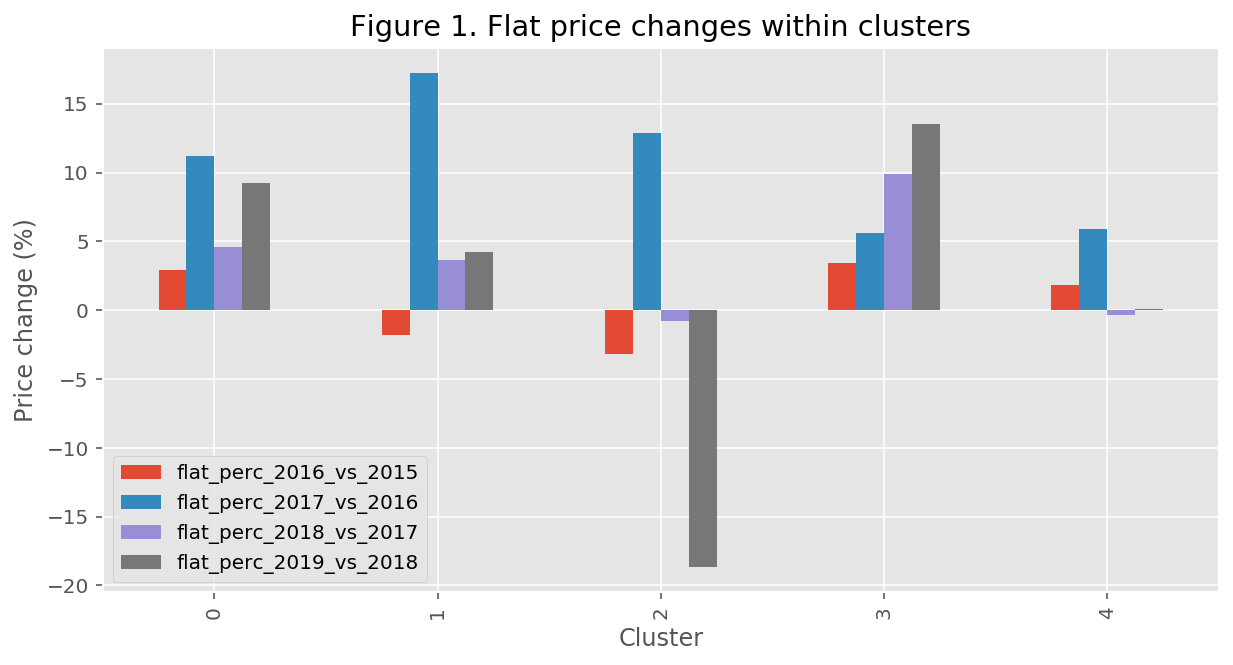

In [50]:
ax = df_cluster_centers[['flat_perc_2016_vs_2015', 'flat_perc_2017_vs_2016', 'flat_perc_2018_vs_2017', 'flat_perc_2019_vs_2018']].plot(kind='bar',
                                                                                                                                       title='Figure 1. Flat price changes within clusters',
                                                                                                                                       figsize=(10,5));
ax.set_xlabel("Cluster");
ax.set_ylabel("Price change (%)");

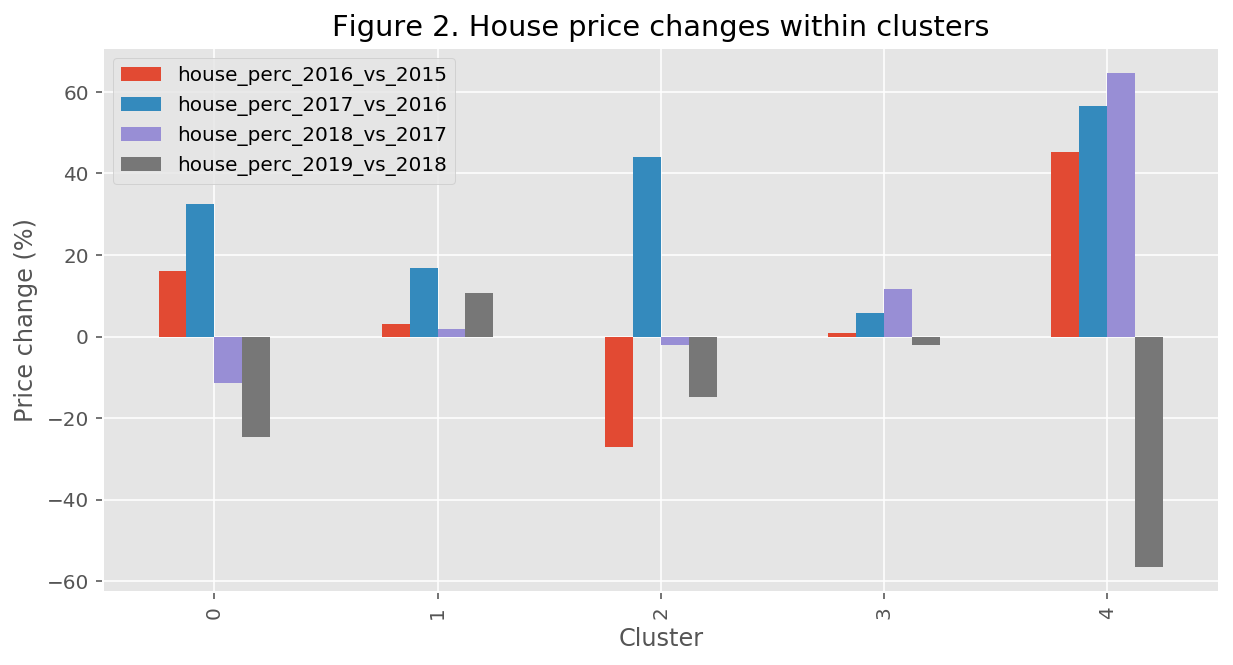

In [51]:
ax = df_cluster_centers[['house_perc_2016_vs_2015', 'house_perc_2017_vs_2016', 'house_perc_2018_vs_2017', 'house_perc_2019_vs_2018']].plot(kind='bar',
                                                                                                                                           title='Figure 2. House price changes within clusters',
                                                                                                                                           figsize=(10,5));
ax.set_xlabel("Cluster");
ax.set_ylabel("Price change (%)");

In [52]:
vilnius_merged_full.loc[vilnius_merged_full['Cluster Labels'] == 0, vilnius_merged_full.columns[[0] + list(range(3, vilnius_merged_full.shape[1]))]]

,neighborhood,distance_to_center,flat_price_per_sqm_2019,flat_perc_2019_vs_2018,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,house_price_per_sqm_2019,house_perc_2019_vs_2018,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Žirmūnai,3.329844,2251.96,9.23,11.2,32.51,1269.5,-24.54,4.57,-11.52,...,Pizza Place,Coffee Shop,Buffet,Seafood Restaurant,Chinese Restaurant,Clothing Store,Gym / Fitness Center,Pet Store,Dance Studio,Dessert Shop


Žirmūnai is the only neighborhood in cluster 0. Comparing 2019 prices per sqm with other clusters, this cluster is second, giving place only to cluster 3 (which is pretty much the city centre). Comparing to clusters other than cluster 3, this neighborhood is much more expensive and prices have been rising more in the past years, so it makes sense why this neighborhood is not within those clusters. I would only wonder why this neighborhood was not included in cluster 3, but maybe it was not the price that made the difference here. Let's take a look at cluster 3 then.

In [53]:
vilnius_merged_full.loc[vilnius_merged_full['Cluster Labels'] == 3, vilnius_merged_full.columns[[0] + list(range(3, vilnius_merged_full.shape[1]))]]

,neighborhood,distance_to_center,flat_price_per_sqm_2019,flat_perc_2019_vs_2018,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,house_price_per_sqm_2019,house_perc_2019_vs_2018,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Antakalnis,3.136690,2159.75,3.85,6.69,-0.66,1204.06,-8.02,10.40,4.72,...,Hotel,Gym / Fitness Center,Pizza Place,Scenic Lookout,Art Gallery,Supermarket,Optical Shop,Park,Dance Studio,Plaza
8,Šnipiškės,2.302548,2735.59,9.85,19.23,5.62,1299.27,-13.16,18.38,18.43,...,Hotel,Coffee Shop,Gym,Massage Studio,Restaurant,Plaza,Pizza Place,Park,Optical Shop,Modern European Restaurant
11,Žvėrynas,2.797418,3044.59,25.29,-3.47,7.59,2346.94,-15.21,7.78,15.77,...,Cosmetics Shop,Bakery,Café,Restaurant,Coffee Shop,Italian Restaurant,Dance Studio,Clothing Store,Dessert Shop,Eastern European Restaurant
15,Naujamiestis,1.504869,2760.94,16.77,6.38,4.35,2051.37,7.32,12.07,23.98,...,Coffee Shop,Café,Pizza Place,Pub,Bed & Breakfast,Bistro,Hookah Bar,Flower Shop,Eastern European Restaurant,Diner
16,Senamiestis,0.000000,3479.34,13.44,-1.18,19.53,2719.29,9.24,8.22,4.32,...,Coffee Shop,Hotel,Plaza,Museum,Vegetarian / Vegan Restaurant,Modern European Restaurant,Spanish Restaurant,Restaurant,Steakhouse,Bookstore
19,Naujininkai,2.535392,1550.47,12.15,5.94,-2.00,921.28,7.09,2.33,3.09,...,Café,Pizza Place,Bar,Hotel,Coffee Shop,Restaurant,Gym,Food Court,Museum,Pub


Comparing cluster 3 (central part of the city) and cluster 0, I would say it's a combination of two things that separated those neighborhoods into two distinct clusters:
1) Housing prices. These seem to be a lot more volatile in the recent years with cluster 0 (Žirmūnai).<br>
2) Differences in location data – the kind of venues in the areas. Cluster 3 has a bunch of bars, pubs, museums, hotels, parks, plazas, which indicate it's a more central part of the city. Cluster 0, on the other hand, is more residential – a pizza place, clothing store, gym, etc.

In [54]:
vilnius_merged_full.loc[vilnius_merged_full['Cluster Labels'] == 1, vilnius_merged_full.columns[[0] + list(range(3, vilnius_merged_full.shape[1]))]]

,neighborhood,distance_to_center,flat_price_per_sqm_2019,flat_perc_2019_vs_2018,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,house_price_per_sqm_2019,house_perc_2019_vs_2018,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Verkiai,7.667949,2542.43,9.17,-2.94,11.59,1234.01,-5.26,9.65,11.96,...,Grocery Store,Park,Burger Joint,Trail,History Museum,Gaming Cafe,Pizza Place,Movie Theater,Italian Restaurant,Hotel
2,Pašilaičiai,6.452166,1346.12,3.04,9.50,19.07,1355.49,7.99,-4.15,23.76,...,Pizza Place,Fast Food Restaurant,Gym,Food & Drink Shop,Gym / Fitness Center,Convenience Store,Electronics Store,Market,Burger Joint,Soccer Field
3,Fabijoniškės,5.563646,1487.74,2.53,4.07,25.06,1085.74,-8.76,2.31,15.77,...,Fast Food Restaurant,Pizza Place,Food & Drink Shop,Gym / Fitness Center,Eastern European Restaurant,Grocery Store,Flower Shop,Food Truck,Market,Electronics Store
4,Pilaitė,7.264573,1527.27,4.42,8.35,8.53,1079.82,4.43,-1.76,6.80,...,Grocery Store,Coffee Shop,Bus Station,Gas Station,Lake,Steakhouse,Supermarket,Kebab Restaurant,Forest,Hotel
5,Justiniškės,5.948139,1561.02,8.75,13.15,25.15,1766.02,28.06,1.15,23.72,...,Supermarket,Pizza Place,Gas Station,Sporting Goods Shop,Shopping Mall,Bus Station,Market,Flea Market,Furniture / Home Store,Cosmetics Shop
7,Šeškinė,4.145797,1777.28,-23.80,20.23,6.57,1750.12,-1.09,29.31,25.74,...,Clothing Store,Pizza Place,Grocery Store,Bakery,Flea Market,Sporting Goods Shop,Soccer Stadium,Shopping Mall,Food & Drink Shop,Flower Shop
10,Karoliniškės,5.010571,2193.33,24.86,5.55,5.03,1326.13,14.76,-7.29,-16.71,...,Grocery Store,Office,Diner,Pizza Place,Bed & Breakfast,Paper / Office Supplies Store,Other Great Outdoors,Restaurant,Fast Food Restaurant,Bowling Alley
12,Grigiškės,12.883530,1076.84,-26.04,117.21,17.03,902.68,19.06,16.31,-14.14,...,Pharmacy,River,Grocery Store,Bus Stop,Yoga Studio,Eastern European Restaurant,Flea Market,Fast Food Restaurant,Farmers Market,Electronics Store
13,Lazdynai,5.103297,1941.58,8.43,10.10,39.97,1317.35,11.96,9.67,-18.28,...,Grocery Store,Pizza Place,Café,Fast Food Restaurant,Park,Restaurant,Gym,Office,TV Station,Soccer Field
14,Vilkpėdė,3.335333,1615.05,6.45,25.04,0.82,760.97,-4.47,-0.32,-7.05,...,Gym,Café,Coffee Shop,Restaurant,Hotel,Food & Drink Shop,Park,Office,Music Venue,Pool


Cluster 1 is the largest cluster of neighborhoods that the clustering model has identified. It is the cheaper neighborhoods having lower price volatility (except for flat price change in 2017), further away from the city centre. Gyms, supermarkets, offices, bus stations and other venus of this kind show these are residential/industrial neighborhoods. It would be interesting to split this cluster into smaller clusters, to see what insights we could get from that.

In [55]:
vilnius_merged_full.loc[vilnius_merged_full['Cluster Labels'] == 2, vilnius_merged_full.columns[[0] + list(range(3, vilnius_merged_full.shape[1]))]]

,neighborhood,distance_to_center,flat_price_per_sqm_2019,flat_perc_2019_vs_2018,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,house_price_per_sqm_2019,house_perc_2019_vs_2018,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Rasos,1.581204,1658.84,-18.66,12.86,44.12,1389.79,-14.9,-0.76,-2.13,...,Bakery,Bar,Hostel,Wine Bar,Dessert Shop,Concert Hall,Coffee Shop,Cocktail Bar,Gym,Bookstore


Rasos is having a cluster of its own. It's quite interesting, this looks to be something in between cluster 1 (residential/industrial) and cluster 3 (city centre). Adding the huge flat price dump in 2019 would explain why this neighborhood might not fit into the other clusters.

In [56]:
vilnius_merged_full.loc[vilnius_merged_full['Cluster Labels'] == 4, vilnius_merged_full.columns[[0] + list(range(3, vilnius_merged_full.shape[1]))]]

,neighborhood,distance_to_center,flat_price_per_sqm_2019,flat_perc_2019_vs_2018,flat_perc_2017_vs_2016,house_perc_2017_vs_2016,house_price_per_sqm_2019,house_perc_2019_vs_2018,flat_perc_2018_vs_2017,house_perc_2018_vs_2017,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Viršuliškės,4.64395,1549.24,0.08,5.89,56.58,1226.92,-56.54,-0.36,64.68,...,Pizza Place,Concert Hall,Soccer Stadium,Shoe Store,Bus Line,Bus Station,Bus Stop,Gym / Fitness Center,Other Great Outdoors,Supermarket


Viršuliškės is the third neighborhood having its own small cluster. Looking at the venues, it seems that this neighborhood should fit into cluster 1 with the other residential neighborhoods. However, the housing market seems to be extremely volatile in this neighborhood lately, with housing prices rising with an average of 50% each year for three years, before plunging down 56% in 2019. This housing marker volatility would explain why this neighborhood is in a cluster of its own.

### Part IV: Discussion

In this project I tried to use location and real estate pricing data to cluster neighborhoods in Vilnius. This is by far not as rigorous as it could be and uses a limited amount of data, but it is nevertheless interesting to see how the neighborhoods are clustered together. Personally, in doing this project I got a nice high-level overview of how the neighborhoods are similar/different to each other and how the prices have been evolving lately. It would be fun to take this data a bit further and do the following: I would like to try using one of the regression methods to train a model on the data of previous years to predict pricing changes for the next year. The amount of data is very little and I am not sure if that would work, but it would still be quite fun. I would especially be interested to see if the cluster that the neighborhood was assigned to would have an effect on the regression output. I will leave that as a future excercise to look into.